# City Safeness - San Francisco

## Introduction/Business Problem

When choosing a place to live people are often concerned about the amount of crimes and/or other accidents like burning fire or traffic accidents. It stays the same when someone is going to start a new business. Knowing that the are is a safe place is one of the humans basic needs.  
This project tries to answer question about what part of San Francisco city seems to be the best place to live according to openly available data

## Data

Data used in this project is publicly available. It will consist of:
1. SF Fire Data (Incidents, Violations, and more) dataset https://www.kaggle.com/san-francisco/sf-fire-data-incidents-violations-and-more
2. SF Police Calls for Service and Incidents dataset 
https://www.kaggle.com/san-francisco/sf-police-calls-for-service-and-incidents
3. SF Geojson https://data.sfgov.org/api/geospatial/pty2-tcw4?method=export&format=GeoJSON

-----

## Preparation

### Libraries

In [1]:
import geocoder

import numpy as np # library to handle data in a vectorized manner
np.random.seed(2018)

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Reading data

Reading police incidents data

In [2]:
sf_police = pd.read_csv('sf-police.csv')
sf_police.head()

,Unnamed: 0,IncidntNum,Category,PdDistrict,X,Y,PdId
0,0,50436712,ASSAULT,MISSION,-122.435003,37.760888,5043671204134
1,1,80049078,LARCENY/THEFT,PARK,-122.446838,37.762255,8004907806304
2,2,130366639,ASSAULT,INGLESIDE,-122.444707,37.724931,13036663904012
3,3,30810835,DRIVING UNDER THE INFLUENCE,SOUTHERN,-122.408954,37.783288,3081083565050
4,4,130839567,OTHER OFFENSES,TENDERLOIN,-122.414056,37.782793,13083956765010


Reading slimmed fire incidents data (whole data is way to big)

In [3]:
sf_fire = pd.read_csv('sf-fire-slim.csv')
sf_fire.head()

,Unnamed: 0,Unnamed: 0.1,Call Number,Call Type,Call Type Group,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location
0,2562324,2562324,110370244,Medical Incident,NaN,MEDIC,1.0,2,6,Tenderloin,"{'latitude': '37.782378943359', 'needs_recodin..."
1,3040510,3040510,123290005,Medical Incident,Potentially Life-Threatening,MEDIC,2.0,6,9,Mission,"{'latitude': '37.752439647175', 'needs_recodin..."
2,4537008,4537008,180014045,Medical Incident,Potentially Life-Threatening,TRUCK,1.0,10,10,Bayview Hunters Point,"{'latitude': '37.72921225449149', 'needs_recod..."
3,3933306,3933306,160170604,Medical Incident,Potentially Life-Threatening,ENGINE,1.0,7,2,Presidio,"{'latitude': '37.788127899431', 'needs_recodin..."
4,2354167,2354167,101130310,Medical Incident,NaN,ENGINE,2.0,10,9,Portola,"{'latitude': '37.7258516225617', 'needs_recodi..."


Geojson file and geo parameters for folium maps

In [4]:
sf_geo = r'SFFindNeighborhoods.geojson' # geojson file
longitude = -122.41942
latitude = 37.77493
zoom = 12

Processing data about police incidents  
1. Renaming column to have consistent name in both datasets  
2. Capitalizing neighborhood names for consistency  
3. Fixing neighborhood names to match those from geoJSON  
4. Grouping by and pivoting data  
5. Fixing indexing  
6. Filling missing data (not all neighborhoods have all the incident types) with zeros  
7. Removing incidents from neighborhood which wasn't identified in geoJSON  
8. Fixing indicies after removing row  
9. Summing into total column


In [5]:
sf_police.rename(index=str, columns={"PdDistrict": "Neighborhood"}, inplace=True)
sf_police['Neighborhood'] = sf_police['Neighborhood'].str.capitalize()

orig_neigh = ['Central', 'Northern', 'Park', 'Richmond', 'Southern']

geojson_neigh = ['Central Waterfront', 'Northern Waterfront', 'Parkside', 'Inner Richmond',
                'South Beach']
sf_police.replace(orig_neigh, geojson_neigh, inplace=True)

sf_police_incidents = sf_police.groupby(['Neighborhood','Category'])['PdId'].count().unstack().copy()
sf_police_incidents = sf_police_incidents.reset_index()
sf_police_incidents.fillna(0, inplace=True)
sf_police_incidents.drop(sf_police_incidents.index[8], inplace=True)
sf_police_incidents = sf_police_incidents.reset_index(drop=True)
sf_police_incidents['Total'] = sf_police_incidents.sum(axis=1)
sf_police_incidents

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total
0,Bayview,1000.0,24812.0,73.0,159.0,9664.0,564.0,457.0,9790.0,575.0,293.0,59.0,180.0,1682.0,2202.0,58.0,805.0,27727.0,275.0,107.0,11269.0,16093.0,40805.0,10.0,139.0,1973.0,6386.0,559.0,4247.0,1057.0,58.0,962.0,78.0,9669.0,4.0,1633.0,14103.0,16876.0,10259.0,4338.0,221000.0
1,Central Waterfront,275.0,17608.0,129.0,46.0,11208.0,1037.0,406.0,4063.0,1203.0,460.0,140.0,58.0,2587.0,5926.0,65.0,427.0,71948.0,272.0,159.0,3573.0,28629.0,22738.0,5.0,1874.0,547.0,5211.0,87.0,1903.0,1050.0,12.0,1469.0,142.0,7543.0,2.0,2437.0,12586.0,10000.0,7102.0,1328.0,226255.0
2,Ingleside,463.0,21971.0,79.0,150.0,8211.0,371.0,521.0,5218.0,463.0,177.0,77.0,173.0,2122.0,2939.0,54.0,754.0,25874.0,218.0,54.0,7882.0,17630.0,32668.0,7.0,80.0,1666.0,6450.0,345.0,3414.0,1361.0,78.0,893.0,159.0,7866.0,1.0,1009.0,13126.0,20625.0,6189.0,2842.0,194180.0
3,Inner Richmond,226.0,7857.0,66.0,24.0,6508.0,233.0,801.0,2207.0,360.0,121.0,67.0,60.0,1365.0,2848.0,12.0,211.0,29117.0,194.0,25.0,3039.0,15059.0,14413.0,5.0,65.0,374.0,1899.0,227.0,1423.0,552.0,24.0,535.0,86.0,5420.0,0.0,641.0,7837.0,9629.0,2525.0,763.0,116818.0
4,Mission,434.0,28791.0,92.0,150.0,9628.0,2611.0,910.0,19251.0,1806.0,316.0,66.0,317.0,2801.0,4811.0,44.0,721.0,48960.0,1058.0,389.0,8126.0,31911.0,47363.0,6.0,7421.0,864.0,8864.0,574.0,3476.0,2001.0,65.0,1585.0,172.0,10359.0,1.0,3000.0,14050.0,17334.0,16202.0,3546.0,300076.0
5,Northern Waterfront,386.0,21058.0,139.0,54.0,14321.0,1135.0,600.0,10751.0,817.0,330.0,65.0,62.0,2831.0,5372.0,23.0,540.0,80988.0,268.0,407.0,4857.0,26485.0,30973.0,7.0,3994.0,799.0,6468.0,202.0,2526.0,1207.0,32.0,1839.0,187.0,8407.0,1.0,2180.0,14533.0,14820.0,11028.0,2021.0,272713.0
6,Parkside,157.0,8637.0,32.0,28.0,7094.0,604.0,422.0,5867.0,792.0,113.0,23.0,46.0,1056.0,2364.0,2.0,189.0,25449.0,289.0,40.0,7357.0,15531.0,15943.0,2.0,18.0,340.0,2225.0,1101.0,1195.0,554.0,17.0,491.0,72.0,4171.0,0.0,822.0,6554.0,9505.0,5460.0,917.0,125479.0
7,South Beach,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0
8,Tenderloin,165.0,18914.0,39.0,41.0,3525.0,1770.0,245.0,38211.0,989.0,272.0,31.0,69.0,1247.0,2666.0,33.0,487.0,24918.0,427.0,360.0,2229.0,18788.0,30652.0,5.0,2000.0,437.0,5322.0,21.0,1750.0,782.0,13.0,839.0,87.0,6511.0,0.0,2698.0,4214.0,2379.0,16549.0,2061.0,191746.0


Getting accumulated police incidents data

In [6]:
police_incident_names = list(sf_police_incidents.columns.values[1:-1])
police_incident_sum = list(sf_police_incidents.sum().values[1:-1])
index = np.arange(len(police_incident_names))
len(index)

39

Most common police incidents

In [7]:
police_sorted = list(np.argsort(np.array(police_incident_sum))[::-1])
for i in range(len(police_sorted)):
    ind = police_sorted[i]
    print(police_incident_names[ind], ' -> ', police_incident_sum[ind])

LARCENY/THEFT  ->  448323.0
OTHER OFFENSES  ->  286958.0
NON-CRIMINAL  ->  219947.0
ASSAULT  ->  180962.0
DRUG/NARCOTIC  ->  116259.0
VEHICLE THEFT  ->  112587.0
VANDALISM  ->  104452.0
WARRANTS  ->  97338.0
BURGLARY  ->  82710.0
SUSPICIOUS OCC  ->  72965.0
MISSING PERSON  ->  56333.0
ROBBERY  ->  52477.0
FRAUD  ->  37569.0
SECONDARY CODES  ->  23055.0
WEAPON LAWS  ->  20832.0
FORGERY/COUNTERFEITING  ->  20771.0
TRESPASS  ->  18325.0
PROSTITUTION  ->  16286.0
STOLEN PROPERTY  ->  11242.0
SEX OFFENSES, FORCIBLE  ->  10763.0
DISORDERLY CONDUCT  ->  9660.0
DRUNKENNESS  ->  9160.0
RECOVERED VEHICLE  ->  7998.0
DRIVING UNDER THE INFLUENCE  ->  5124.0
KIDNAPPING  ->  4894.0
LIQUOR LAWS  ->  3813.0
ARSON  ->  3590.0
RUNAWAY  ->  3362.0
EMBEZZLEMENT  ->  2737.0
LOITERING  ->  2357.0
SUICIDE  ->  1143.0
FAMILY OFFENSES  ->  1087.0
BAD CHECKS  ->  825.0
BRIBERY  ->  760.0
EXTORTION  ->  626.0
SEX OFFENSES, NON FORCIBLE  ->  368.0
GAMBLING  ->  330.0
PORNOGRAPHY/OBSCENE MAT  ->  53.0
TREA  ->  11

Plotting data to show police incidents accumulated sum

In [8]:
#plt.bar(index, police_incident_sum)
#plt.xlabel('Incident names', fontsize=5)
#plt.ylabel('Accumulated count', fontsize=5)
#plt.title('Accumulated count of incidents')
#plt.xticks(index, police_incident_names, fontsize=5, rotation=30)
plt.rcParams["figure.figsize"] = [32,18]
#plt.show()

There are way to much incidents type to build just a one plot

Building many plots to show them

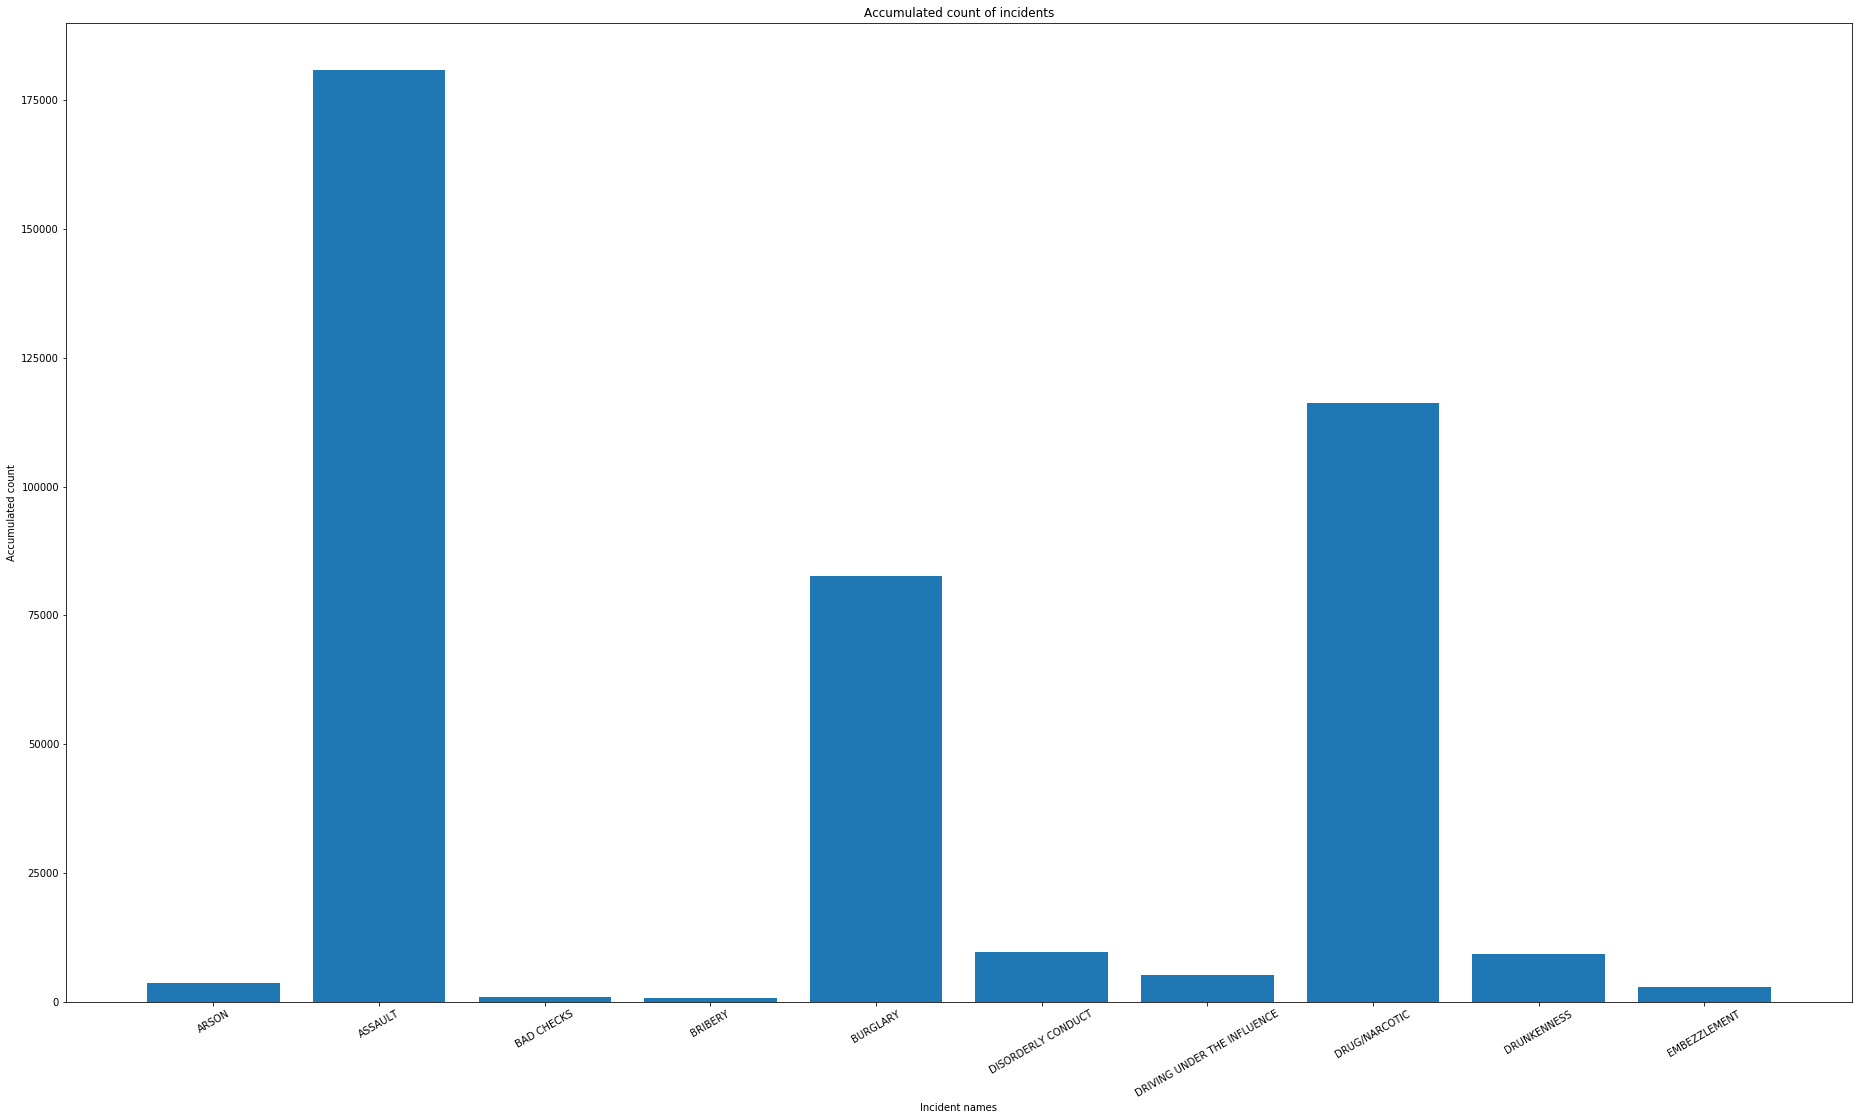

In [9]:
plt.bar(index[:10], police_incident_sum[:10])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:10], police_incident_names[:10], rotation=30)
plt.show()

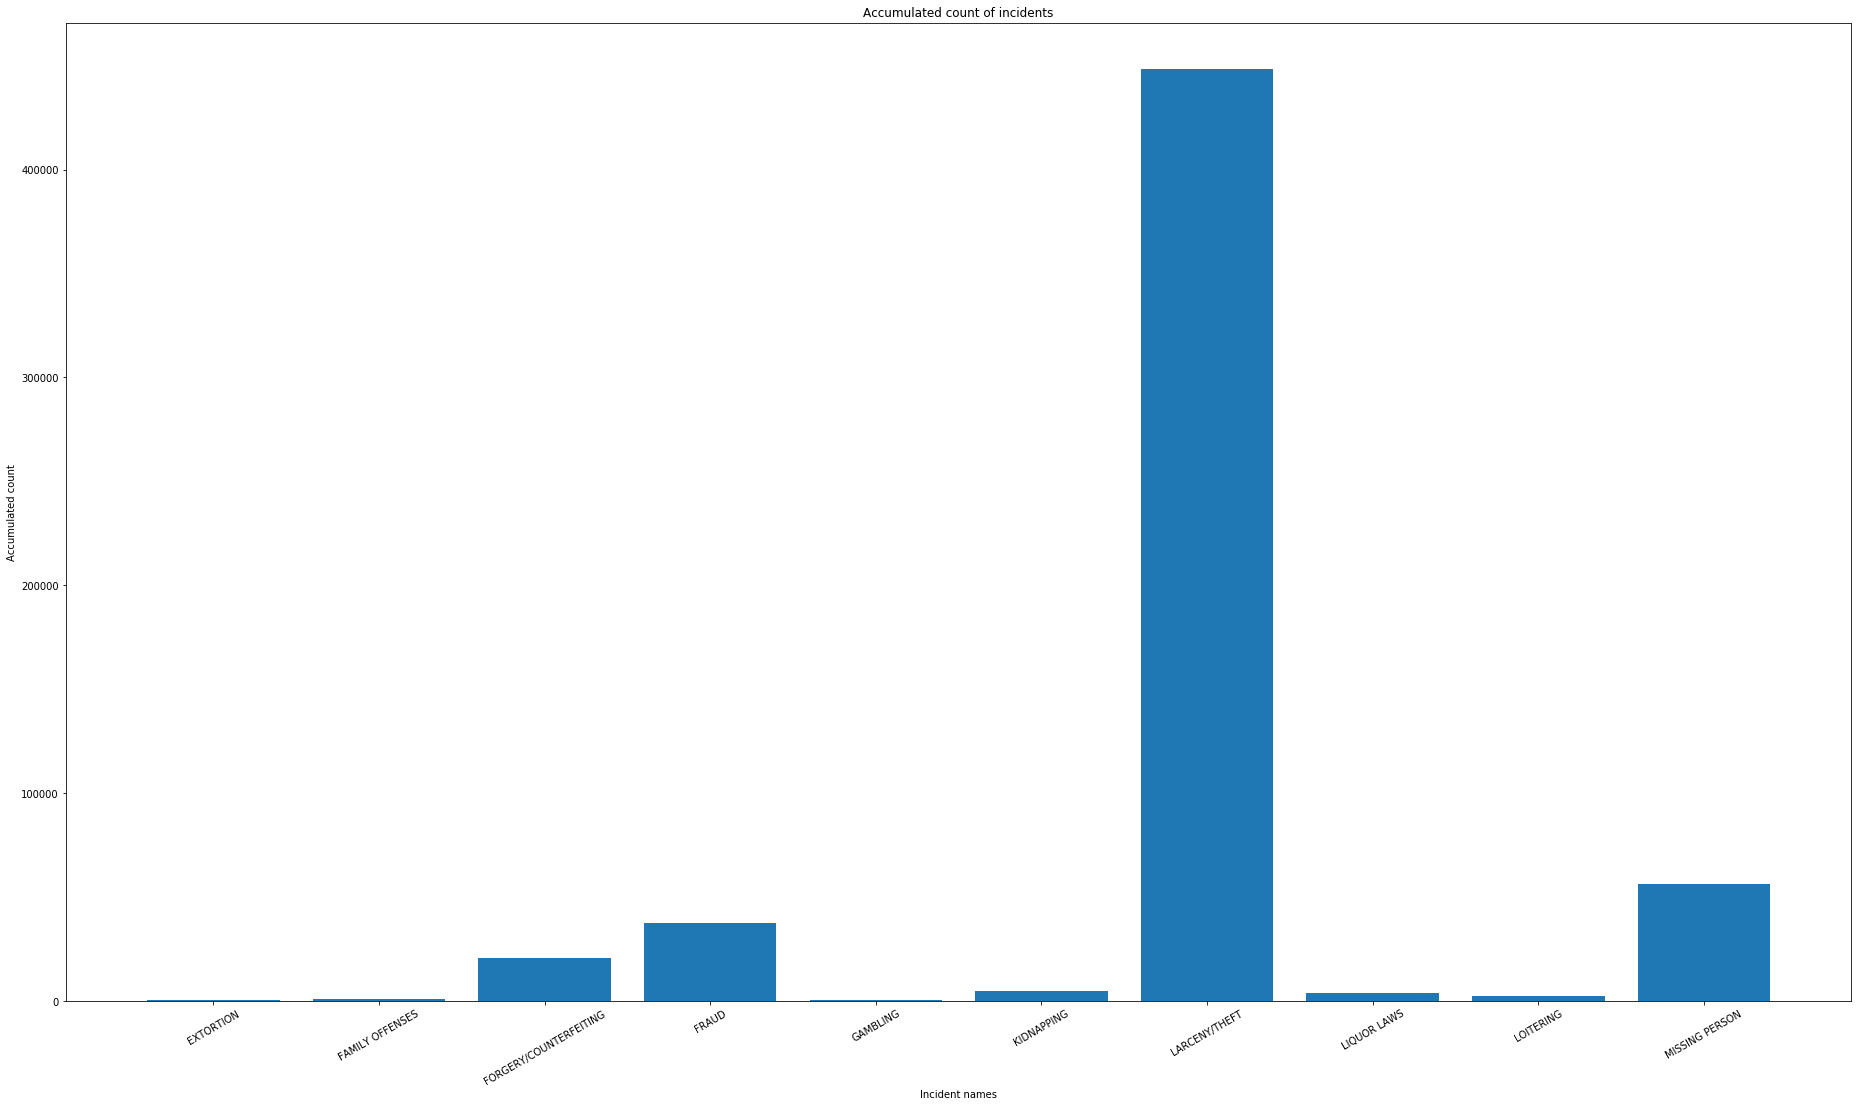

In [10]:
plt.bar(index[:10], police_incident_sum[10:20])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:10], police_incident_names[10:20], rotation=30)
plt.show()

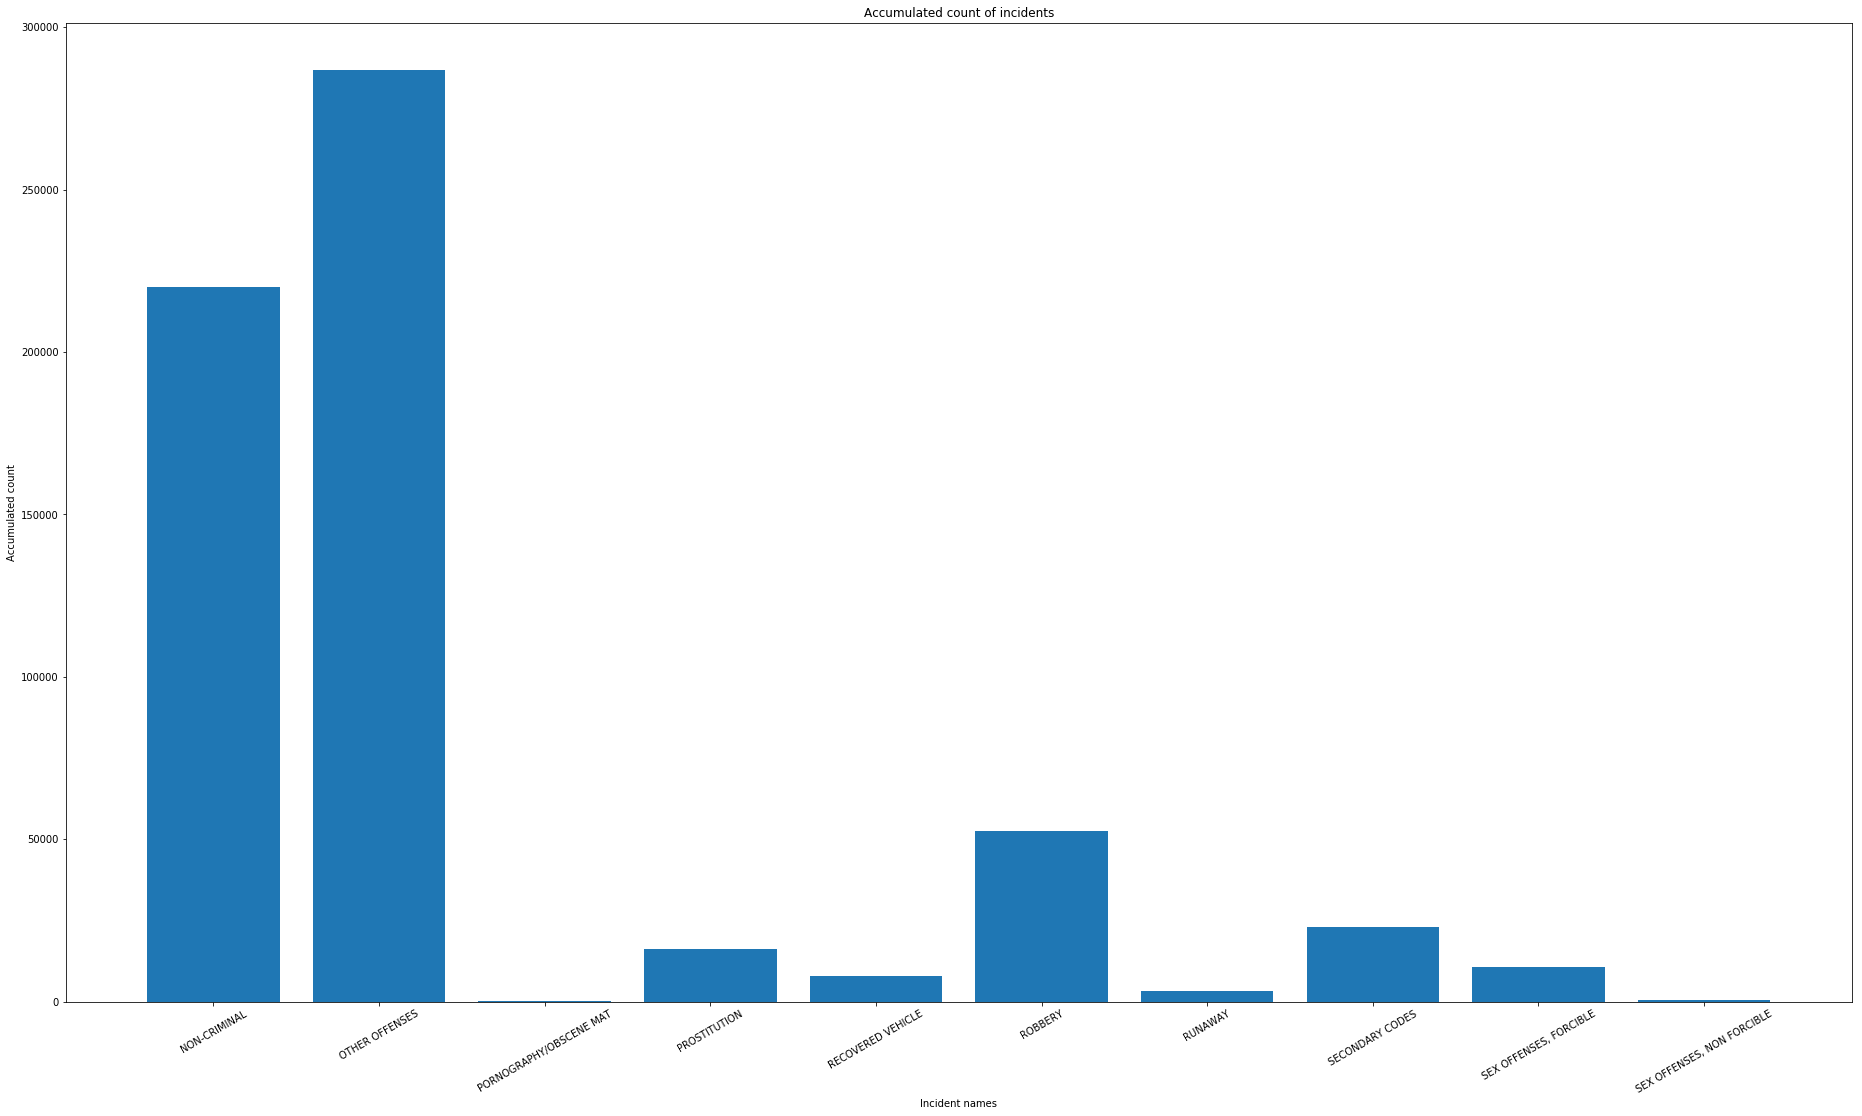

In [11]:
plt.bar(index[:10], police_incident_sum[20:30])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:10], police_incident_names[20:30], rotation=30)
plt.show()

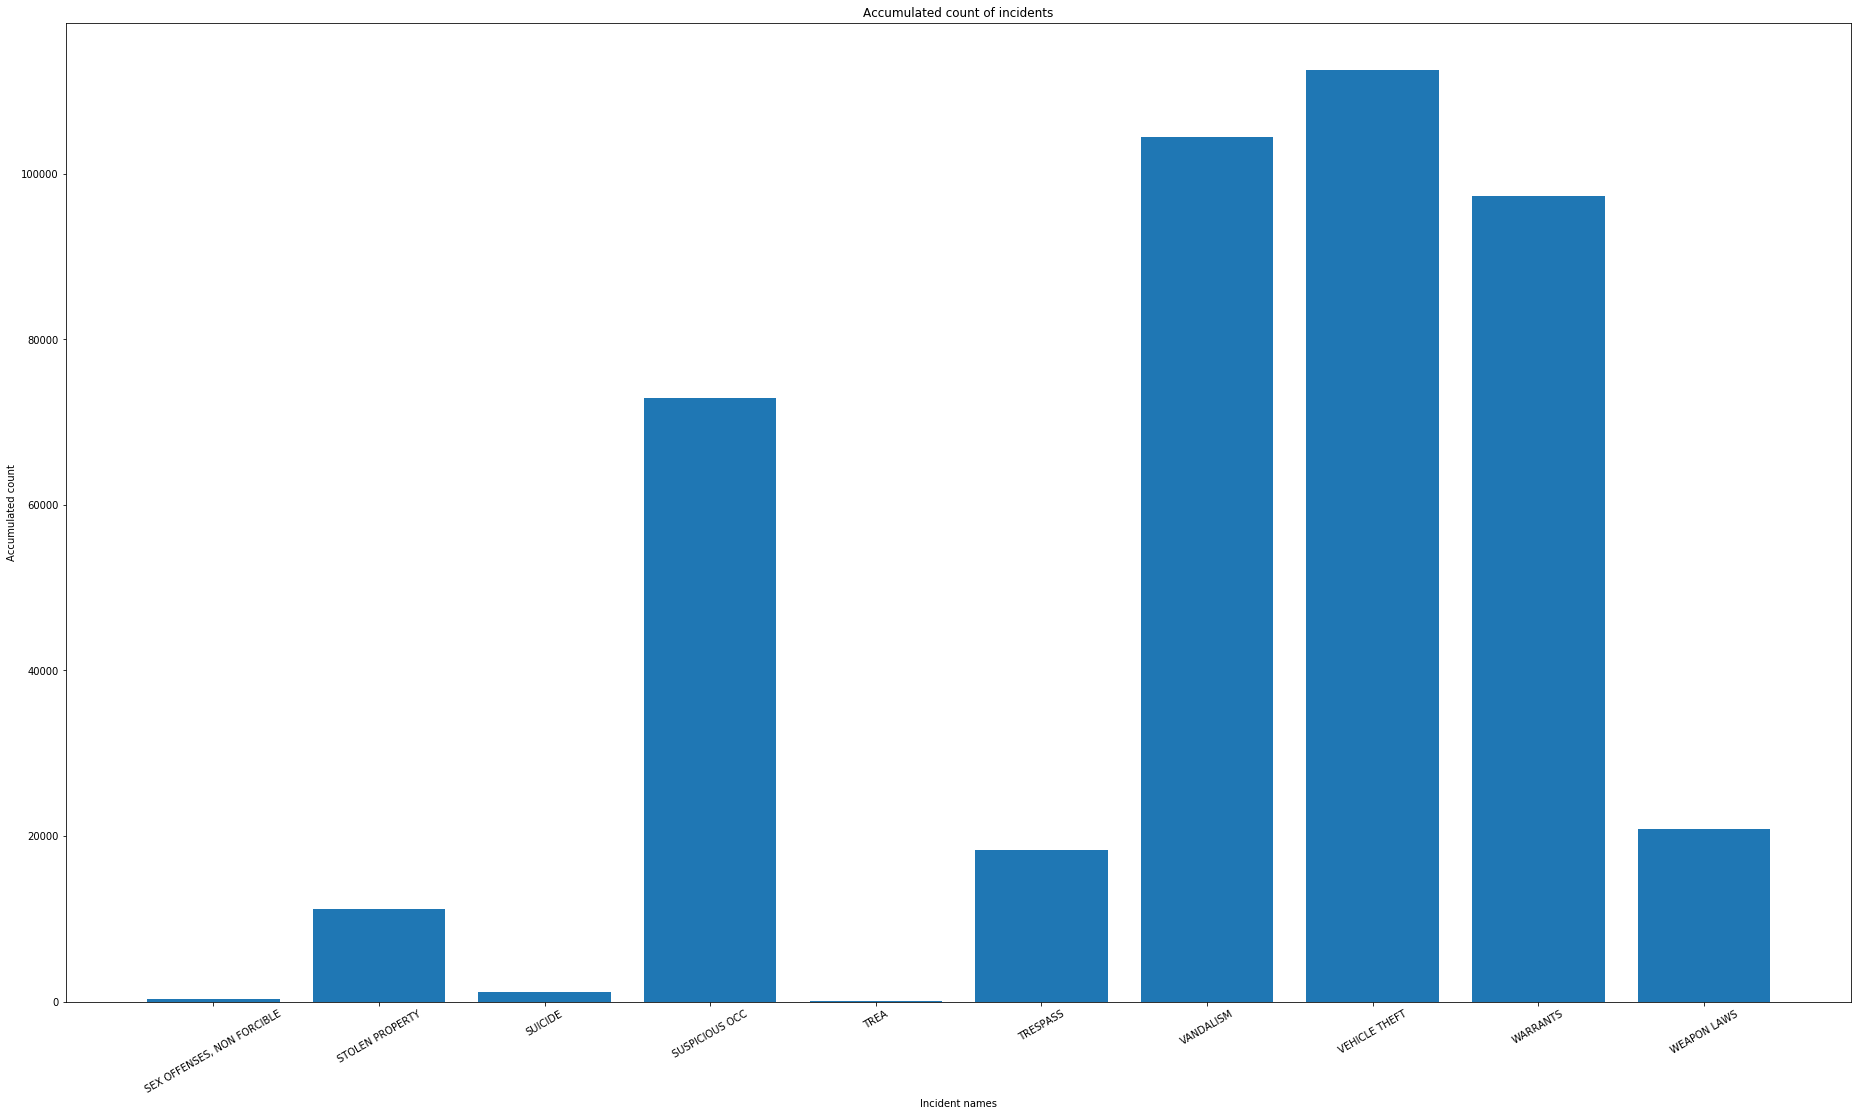

In [12]:
plt.bar(index[:10], police_incident_sum[29:])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:10], police_incident_names[29:], rotation=30)
plt.show()

Map of police incidents by neighborhoods

In [13]:
# create a plain world map
police_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles='Mapbox Bright')

# generate choropleth map
police_map.choropleth(
    geo_data=sf_geo,
    data=sf_police_incidents,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Police incidents'
)

# display map
police_map

Processing data about fire incidents  
1. Renaming column to have consistent name in both datasets  
2. Fixing neighborhood names to match those from geoJSON  
3. Grouping by and pivoting data  
5. Fixing indexing  
6. Filling missing data (not all neighborhoods have all the incident types) with zeros  
7. Removing incidents from neighborhood which wasn't identified in geoJSON  
8. Fixing indicies after removing row  
9. Summing into total column


In [14]:
sf_fire.rename(index=str, columns={"Neighborhooods - Analysis Boundaries": "Neighborhood", "Call Type": "Category"}, inplace=True)

orig_neigh = ['Bayview Hunters Point', 'Castro/Upper Market', 'Financial District/South Beach', 
              'Lincoln Park', 'Lone Mountain/USF', 'Oceanview/Merced/Ingleside', 'Presidio',
             'Sunset/Parkside']

geojson_neigh = ['Bayview', 'Castro', 'Financial District', 'Lincoln Park / Ft. Miley', 
                 'Lone Mountain', 'Oceanview', 'Presidio Terrace', 'Inner Sunset']
sf_fire.replace(orig_neigh, geojson_neigh, inplace=True)

sf_fire_incidents = sf_fire.groupby(['Neighborhood','Category'])['Call Number'].count().unstack().copy()
sf_fire_incidents = sf_fire_incidents.reset_index()
sf_fire_incidents.fillna(0, inplace=True)
sf_fire_incidents.drop(sf_fire_incidents.index[[22,38, 40]], inplace=True)
sf_fire_incidents = sf_fire_incidents.reset_index(drop=True)
sf_fire_incidents['Total'] = sf_fire_incidents.sum(axis=1)
sf_fire_incidents

Category,Neighborhood,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total
0,Bayview,11.0,0.0,3555.0,28.0,1075.0,2.0,235.0,48.0,21.0,24.0,83.0,296.0,95.0,4.0,97.0,0.0,10.0,41045.0,0.0,187.0,10.0,1157.0,1929.0,272.0,10413.0,8.0,2648.0,0.0,10.0,1023.0,120.0,33.0,64439.0
1,Bernal Heights,1.0,0.0,1308.0,12.0,399.0,0.0,98.0,15.0,11.0,9.0,76.0,133.0,36.0,2.0,16.0,0.0,0.0,14324.0,0.0,76.0,2.0,413.0,359.0,115.0,3615.0,2.0,1498.0,0.0,1.0,200.0,12.0,0.0,22733.0
2,Castro,5.0,0.0,2303.0,10.0,445.0,6.0,88.0,56.0,11.0,3.0,47.0,120.0,27.0,1.0,16.0,0.0,0.0,18638.0,0.0,69.0,2.0,459.0,327.0,87.0,4710.0,0.0,1130.0,0.0,9.0,121.0,0.0,0.0,28690.0
3,Chinatown,2.0,0.0,4011.0,2.0,271.0,7.0,17.0,131.0,15.0,1.0,14.0,73.0,17.0,6.0,9.0,0.0,0.0,15074.0,0.0,64.0,6.0,334.0,154.0,22.0,4130.0,0.0,689.0,0.0,0.0,39.0,2.0,0.0,25090.0
4,Excelsior,0.0,0.0,747.0,7.0,364.0,1.0,152.0,4.0,27.0,2.0,31.0,82.0,12.0,0.0,1.0,0.0,0.0,16946.0,0.0,74.0,4.0,328.0,157.0,53.0,3896.0,0.0,946.0,0.0,0.0,133.0,0.0,0.0,23967.0
5,Financial District,4.0,0.0,17885.0,26.0,630.0,12.0,77.0,498.0,78.0,21.0,82.0,177.0,144.0,21.0,127.0,0.0,21.0,44495.0,1.0,141.0,22.0,1070.0,1798.0,120.0,8593.0,24.0,3597.0,0.0,152.0,294.0,799.0,20.0,80929.0
6,Glen Park,0.0,0.0,551.0,2.0,190.0,2.0,33.0,2.0,2.0,0.0,9.0,43.0,5.0,0.0,2.0,0.0,0.0,3339.0,0.0,34.0,1.0,130.0,73.0,23.0,899.0,0.0,184.0,0.0,4.0,26.0,5.0,0.0,5559.0
7,Golden Gate Park,0.0,0.0,348.0,3.0,86.0,0.0,18.0,2.0,0.0,2.0,18.0,10.0,4.0,0.0,7.0,0.0,0.0,4320.0,0.0,14.0,1.0,122.0,322.0,42.0,440.0,2.0,1069.0,0.0,0.0,85.0,162.0,0.0,7077.0
8,Haight Ashbury,0.0,0.0,1793.0,4.0,276.0,3.0,72.0,8.0,9.0,7.0,39.0,119.0,9.0,0.0,3.0,0.0,0.0,11525.0,0.0,100.0,7.0,319.0,205.0,51.0,3194.0,3.0,599.0,0.0,5.0,73.0,0.0,0.0,18423.0
9,Hayes Valley,2.0,0.0,3087.0,3.0,385.0,6.0,102.0,67.0,4.0,5.0,46.0,153.0,22.0,0.0,13.0,0.0,0.0,18211.0,0.0,101.0,4.0,414.0,281.0,65.0,4440.0,1.0,1675.0,0.0,0.0,109.0,9.0,0.0,29205.0


Getting accumulated fire incidents data

In [15]:
fire_incident_names = list(sf_fire_incidents.columns.values[1:-1])
fire_incident_sum = list(sf_fire_incidents.sum().values[1:-1])
index = np.arange(len(fire_incident_names))
len(index)

32

Most common fire incidents

In [16]:
fire_sorted = list(np.argsort(np.array(fire_incident_sum))[::-1])
for i in range(len(fire_sorted)):
    ind = fire_sorted[i]
    print(fire_incident_names[ind], ' -> ', fire_incident_sum[ind])

Medical Incident  ->  732722.0
Structure Fire  ->  148014.0
Alarms  ->  119796.0
Traffic Collision  ->  46823.0
Citizen Assist / Service Call  ->  16762.0
Other  ->  15863.0
Outside Fire  ->  13320.0
Water Rescue  ->  5569.0
Vehicle Fire  ->  5444.0
Gas Leak (Natural and LP Gases)  ->  4204.0
Electrical Hazard  ->  3306.0
Odor (Strange / Unknown)  ->  3018.0
Elevator / Escalator Rescue  ->  2933.0
Smoke Investigation (Outside)  ->  2545.0
Fuel Spill  ->  1385.0
HazMat  ->  934.0
Industrial Accidents  ->  668.0
Explosion  ->  641.0
Train / Rail Incident  ->  325.0
Assist Police  ->  320.0
High Angle Rescue  ->  284.0
Extrication / Entrapped (Machinery, Vehicle)  ->  184.0
Watercraft in Distress  ->  184.0
Oil Spill  ->  125.0
Confined Space / Structure Collapse  ->  121.0
Mutual Aid / Assist Outside Agency  ->  114.0
Marine Fire  ->  105.0
Suspicious Package  ->  80.0
Administrative  ->  60.0
Aircraft Emergency  ->  22.0
Train / Rail Fire  ->  3.0
Lightning Strike (Investigation)  ->  1

Plotting data to show fire incidents accumulated sum

In [17]:
#plt.bar(index, fire_incident_sum)
#plt.xlabel('Incident names', fontsize=5)
#plt.ylabel('Accumulated count', fontsize=5)
#plt.title('Accumulated count of incidents')
#plt.xticks(index, fire_incident_names, fontsize=5, rotation=30)
#plt.show()

There are way to much incidents type to build just a one plot

Building many plots to show them

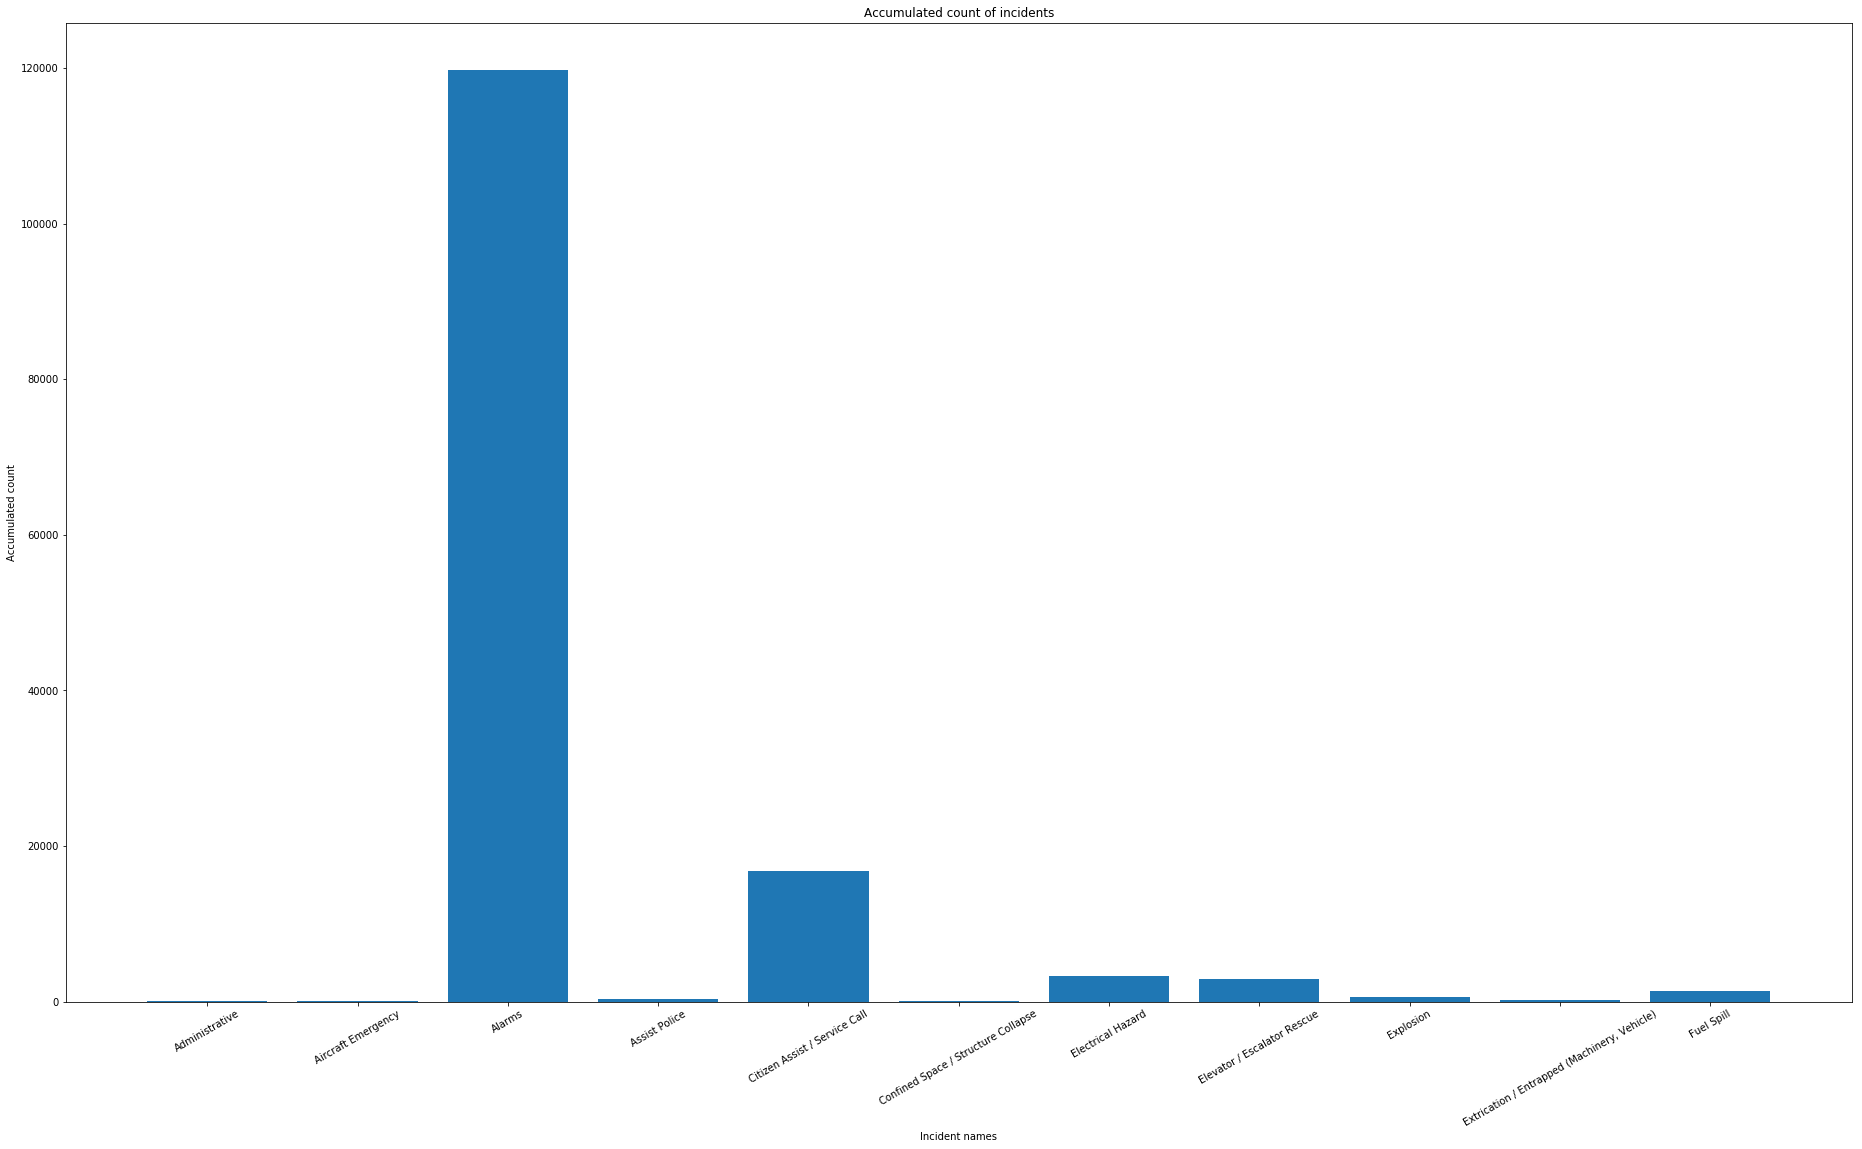

In [18]:
plt.bar(index[:11], fire_incident_sum[:11])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:11], fire_incident_names[:11], rotation=30)
plt.show()

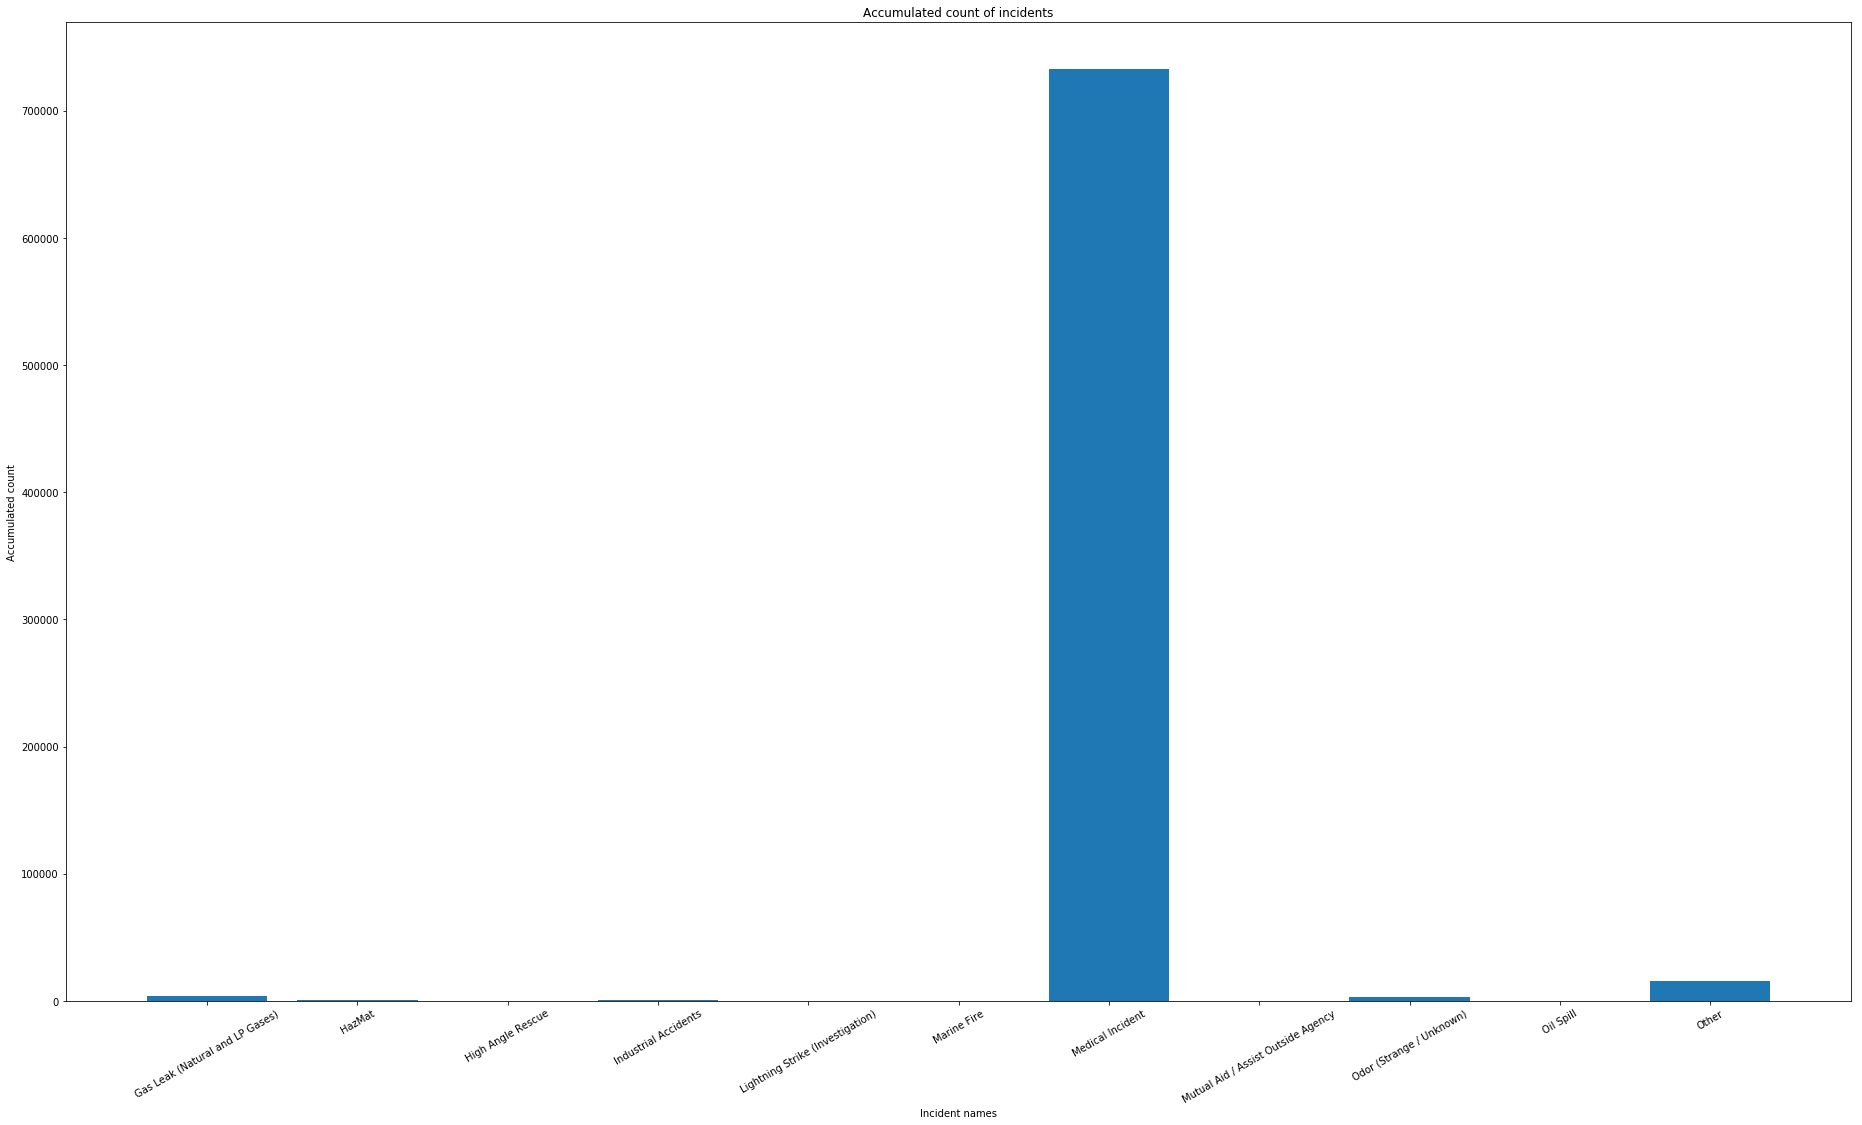

In [19]:
plt.bar(index[:11], fire_incident_sum[11:22])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:11], fire_incident_names[11:22], rotation=30)
plt.show()

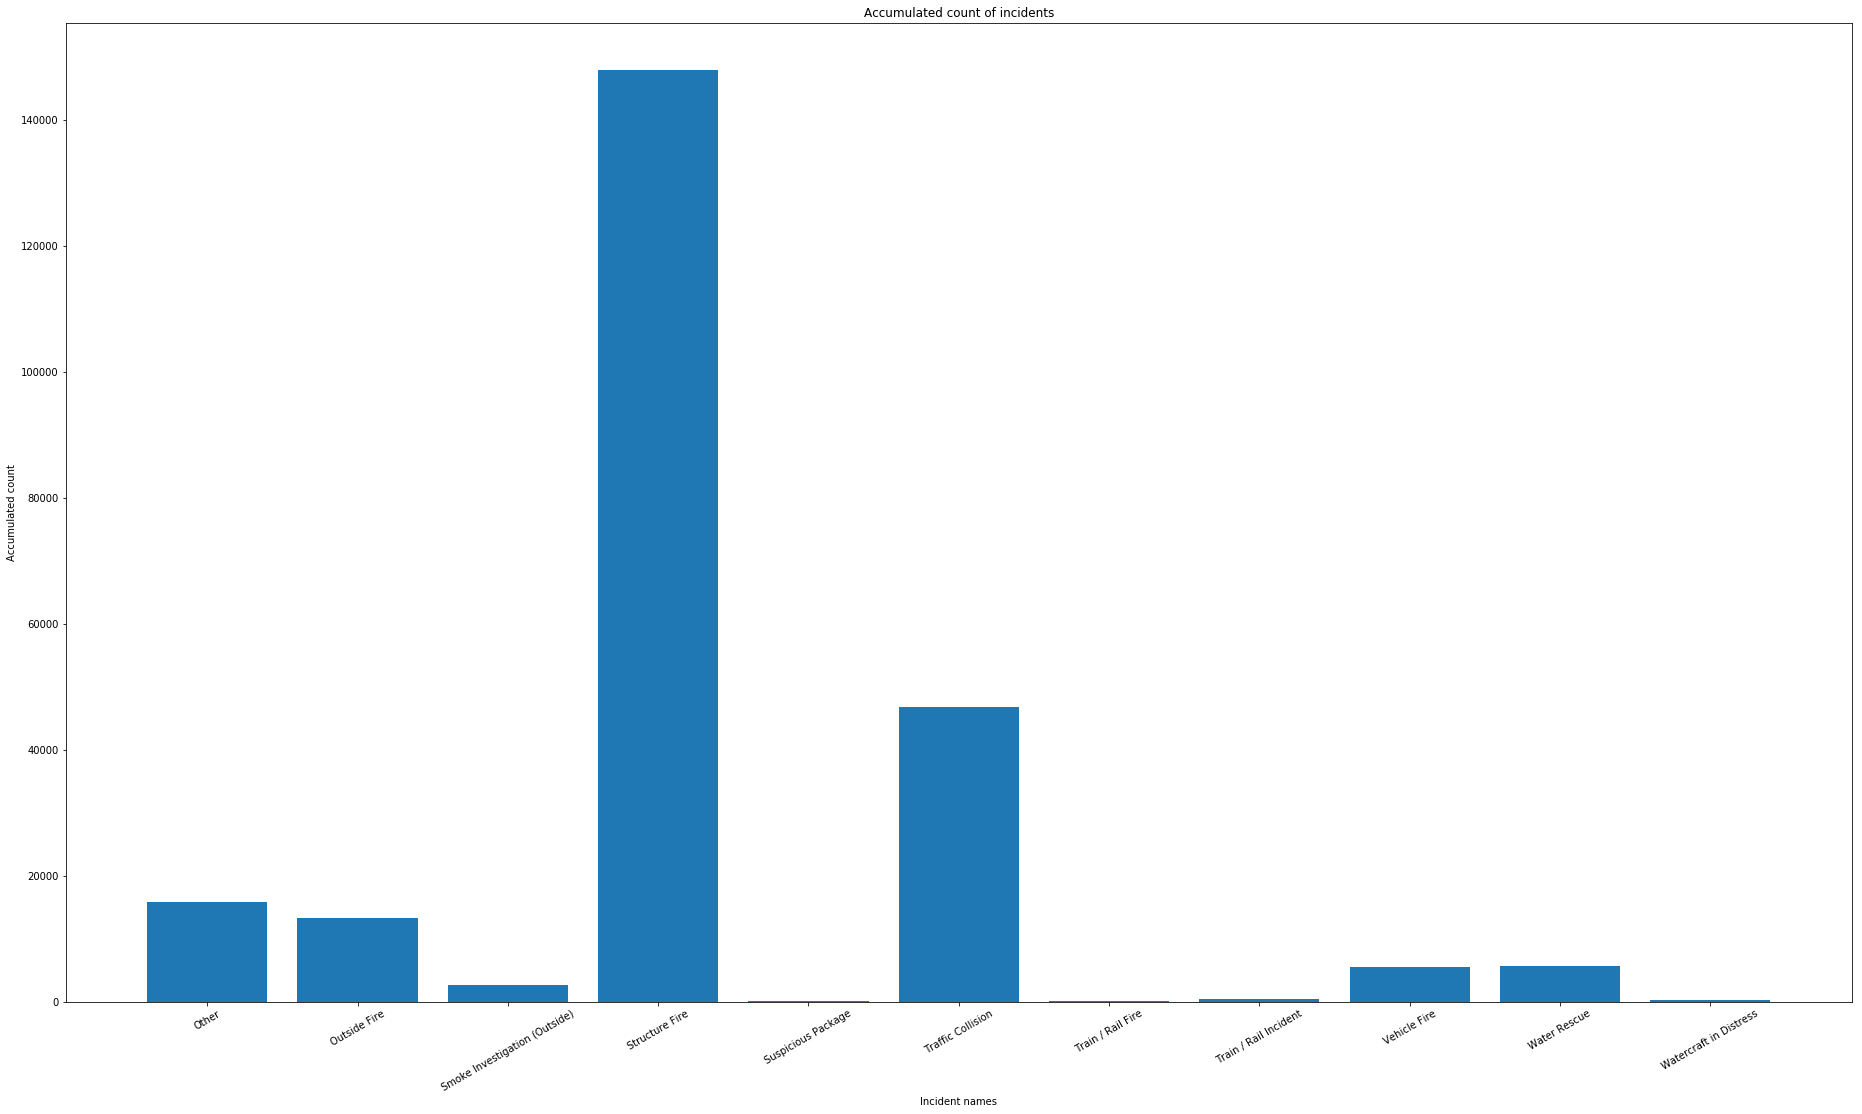

In [20]:
plt.bar(index[:11], fire_incident_sum[21:])
plt.xlabel('Incident names')
plt.ylabel('Accumulated count')
plt.title('Accumulated count of incidents')
plt.xticks(index[:11], fire_incident_names[21:], rotation=30)
plt.show()

Map of fire incidents by neighborhoods

In [21]:
# create a plain world map
fire_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles='Mapbox Bright')

fire_map.choropleth(
    geo_data=sf_geo,
    data=sf_fire_incidents,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Fire incidents'
)

# display map
fire_map

Combining incident data  
1. Merging on 'Neighborhood' column using full outer join to get whole data from both datasets  
2. Filling NA's with 0, as not all the neighborhhods have data in both datasets  
3. Adding column for storing accumulated total  
4. Renaming columns from 'Total_x' and 'Total_y' to more meaningful

In [22]:
merged_incidents = sf_police_incidents.merge(sf_fire_incidents, how='outer', on='Neighborhood')
merged_incidents.fillna(0, inplace=True)
merged_incidents['Total'] = merged_incidents['Total_x'] + merged_incidents['Total_y']
merged_incidents.rename(index=str, columns={"Total_x": "Total_police", "Total_y": "Total_fire"}, inplace=True)
merged_incidents

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total
0,Bayview,1000.0,24812.0,73.0,159.0,9664.0,564.0,457.0,9790.0,575.0,293.0,59.0,180.0,1682.0,2202.0,58.0,805.0,27727.0,275.0,107.0,11269.0,16093.0,40805.0,10.0,139.0,1973.0,6386.0,559.0,4247.0,1057.0,58.0,962.0,78.0,9669.0,4.0,1633.0,14103.0,16876.0,10259.0,4338.0,221000.0,11.0,0.0,3555.0,28.0,1075.0,2.0,235.0,48.0,21.0,24.0,83.0,296.0,95.0,4.0,97.0,0.0,10.0,41045.0,0.0,187.0,10.0,1157.0,1929.0,272.0,10413.0,8.0,2648.0,0.0,10.0,1023.0,120.0,33.0,64439.0,285439.0
1,Central Waterfront,275.0,17608.0,129.0,46.0,11208.0,1037.0,406.0,4063.0,1203.0,460.0,140.0,58.0,2587.0,5926.0,65.0,427.0,71948.0,272.0,159.0,3573.0,28629.0,22738.0,5.0,1874.0,547.0,5211.0,87.0,1903.0,1050.0,12.0,1469.0,142.0,7543.0,2.0,2437.0,12586.0,10000.0,7102.0,1328.0,226255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226255.0
2,Ingleside,463.0,21971.0,79.0,150.0,8211.0,371.0,521.0,5218.0,463.0,177.0,77.0,173.0,2122.0,2939.0,54.0,754.0,25874.0,218.0,54.0,7882.0,17630.0,32668.0,7.0,80.0,1666.0,6450.0,345.0,3414.0,1361.0,78.0,893.0,159.0,7866.0,1.0,1009.0,13126.0,20625.0,6189.0,2842.0,194180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194180.0
3,Inner Richmond,226.0,7857.0,66.0,24.0,6508.0,233.0,801.0,2207.0,360.0,121.0,67.0,60.0,1365.0,2848.0,12.0,211.0,29117.0,194.0,25.0,3039.0,15059.0,14413.0,5.0,65.0,374.0,1899.0,227.0,1423.0,552.0,24.0,535.0,86.0,5420.0,0.0,641.0,7837.0,9629.0,2525.0,763.0,116818.0,0.0,0.0,1655.0,12.0,329.0,0.0,94.0,18.0,6.0,0.0,20.0,90.0,8.0,0.0,7.0,0.0,0.0,11053.0,0.0,74.0,2.0,256.0,149.0,42.0,2333.0,0.0,941.0,0.0,0.0,65.0,0.0,0.0,17154.0,133972.0
4,Mission,434.0,28791.0,92.0,150.0,9628.0,2611.0,910.0,19251.0,1806.0,316.0,66.0,317.0,2801.0,4811.0,44.0,721.0,48960.0,1058.0,389.0,8126.0,31911.0,47363.0,6.0,7421.0,864.0,8864.0,574.0,3476.0,2001.0,65.0,1585.0,172.0,10359.0,1.0,3000.0,14050.0,17334.0,16202.0,3546.0,300076.0,21.0,0.0,7755.0,20.0,1327.0,6.0,259.0,157.0,58.0,10.0,139.0,365.0,61.0,1.0,29.0,0.0,0.0,73915.0,111.0,265.0,13.0,1366.0,1097.0,189.0,15820.0,6.0,5047.0,0.0,35.0,449.0,0.0,0.0,108521.0,408597.0
5,Northern Waterfront,386.0,21058.0,139.0,54.0,14321.0,1135.0,600.0,10751.0,817.0,330.0,65.0,62.0,2831.0,5372.0,23.0,540.0,80988.0,268.0,407.0,4857.0,26485.0,30973.0,7.0,3994.0,799.0,6468.0,202.0,2526.0,1207.0,32.0,1839.0,187.0,8407.0,1.0,2180.0,14533.0,14820.0,11028.0,2021.0,272713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272713.0
6,Parkside,157.0,8637.0,32.0,28.0,7094.0,604.0,422.0,5867.0,792.0,113.0,23.0,46.0,1056.0,2364.0,2.0,189.0,25449.0,289.0,40.0,7357.0,15531.0,15943.0,2.0,18.0,

Combined map

In [23]:
# create a plain world map
merged_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles='Mapbox Bright')


merged_map.choropleth(
    geo_data=sf_geo,
    data=merged_incidents,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Incidents clustering'
)

# display map
merged_map

10 safest neighborhoods based on total

In [24]:
safest_ones = list(merged_incidents.sort_values(by=['Total']).head(10)['Neighborhood'].values)
safest_ones

['Lincoln Park / Ft. Miley',
 'McLaren Park',
 'Seacliff',
 'Presidio Terrace',
 'Glen Park',
 'Twin Peaks',
 'Golden Gate Park',
 'Treasure Island',
 'Japantown',
 'Presidio Heights']

## Clusters

Run k-means to cluster the neighborhood into 6 clusters.

In [25]:
# set number of clusters
kclusters = 6

sf_clustering = merged_incidents.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2018).fit(sf_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 5, 5, 2, 1, 5, 4, 2, 0], dtype=int32)

Makind new dataset with labels

In [26]:
sf_clustered = merged_incidents.copy()

# add clustering labels
sf_clustered['Cluster Labels'] = kmeans.labels_

sf_clustered

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
0,Bayview,1000.0,24812.0,73.0,159.0,9664.0,564.0,457.0,9790.0,575.0,293.0,59.0,180.0,1682.0,2202.0,58.0,805.0,27727.0,275.0,107.0,11269.0,16093.0,40805.0,10.0,139.0,1973.0,6386.0,559.0,4247.0,1057.0,58.0,962.0,78.0,9669.0,4.0,1633.0,14103.0,16876.0,10259.0,4338.0,221000.0,11.0,0.0,3555.0,28.0,1075.0,2.0,235.0,48.0,21.0,24.0,83.0,296.0,95.0,4.0,97.0,0.0,10.0,41045.0,0.0,187.0,10.0,1157.0,1929.0,272.0,10413.0,8.0,2648.0,0.0,10.0,1023.0,120.0,33.0,64439.0,285439.0,1
1,Central Waterfront,275.0,17608.0,129.0,46.0,11208.0,1037.0,406.0,4063.0,1203.0,460.0,140.0,58.0,2587.0,5926.0,65.0,427.0,71948.0,272.0,159.0,3573.0,28629.0,22738.0,5.0,1874.0,547.0,5211.0,87.0,1903.0,1050.0,12.0,1469.0,142.0,7543.0,2.0,2437.0,12586.0,10000.0,7102.0,1328.0,226255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226255.0,1
2,Ingleside,463.0,21971.0,79.0,150.0,8211.0,371.0,521.0,5218.0,463.0,177.0,77.0,173.0,2122.0,2939.0,54.0,754.0,25874.0,218.0,54.0,7882.0,17630.0,32668.0,7.0,80.0,1666.0,6450.0,345.0,3414.0,1361.0,78.0,893.0,159.0,7866.0,1.0,1009.0,13126.0,20625.0,6189.0,2842.0,194180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194180.0,5
3,Inner Richmond,226.0,7857.0,66.0,24.0,6508.0,233.0,801.0,2207.0,360.0,121.0,67.0,60.0,1365.0,2848.0,12.0,211.0,29117.0,194.0,25.0,3039.0,15059.0,14413.0,5.0,65.0,374.0,1899.0,227.0,1423.0,552.0,24.0,535.0,86.0,5420.0,0.0,641.0,7837.0,9629.0,2525.0,763.0,116818.0,0.0,0.0,1655.0,12.0,329.0,0.0,94.0,18.0,6.0,0.0,20.0,90.0,8.0,0.0,7.0,0.0,0.0,11053.0,0.0,74.0,2.0,256.0,149.0,42.0,2333.0,0.0,941.0,0.0,0.0,65.0,0.0,0.0,17154.0,133972.0,5
4,Mission,434.0,28791.0,92.0,150.0,9628.0,2611.0,910.0,19251.0,1806.0,316.0,66.0,317.0,2801.0,4811.0,44.0,721.0,48960.0,1058.0,389.0,8126.0,31911.0,47363.0,6.0,7421.0,864.0,8864.0,574.0,3476.0,2001.0,65.0,1585.0,172.0,10359.0,1.0,3000.0,14050.0,17334.0,16202.0,3546.0,300076.0,21.0,0.0,7755.0,20.0,1327.0,6.0,259.0,157.0,58.0,10.0,139.0,365.0,61.0,1.0,29.0,0.0,0.0,73915.0,111.0,265.0,13.0,1366.0,1097.0,189.0,15820.0,6.0,5047.0,0.0,35.0,449.0,0.0,0.0,108521.0,408597.0,2
5,Northern Waterfront,386.0,21058.0,139.0,54.0,14321.0,1135.0,600.0,10751.0,817.0,330.0,65.0,62.0,2831.0,5372.0,23.0,540.0,80988.0,268.0,407.0,4857.0,26485.0,30973.0,7.0,3994.0,799.0,6468.0,202.0,2526.0,1207.0,32.0,1839.0,187.0,8407.0,1.0,2180.0,14533.0,14820.0,11028.0,2021.0,272713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272713.0,1
6,Parkside,157.0,8637.0,32.0,28.0,7094.0,604.0,422.0,5867.0,792.0,113.0,23.0,46.0,1056.0,2364.0,2.0,189.0,25449.0,289.0,40.0,7357.

Show clusters of 10 safest ones

In [27]:
sf_clustered.loc[sf_clustered['Neighborhood'].isin(safest_ones)][['Neighborhood', 'Cluster Labels']]

Category,Neighborhood,Cluster Labels
14,Glen Park,0
15,Golden Gate Park,0
19,Japantown,0
21,Lincoln Park / Ft. Miley,0
24,McLaren Park,0
35,Presidio Heights,0
36,Presidio Terrace,0
38,Seacliff,0
40,Treasure Island,0
41,Twin Peaks,0


Clustered map

In [28]:
# create a plain world map
clustered_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles='Mapbox Bright')

clustered_map.choropleth(
    geo_data=sf_geo,
    data=sf_clustered,
    columns=['Neighborhood', 'Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Incidents clustering'
)

# display map
clustered_map

### Cluster 1

In [29]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 0]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
9,Bernal Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1308.0,12.0,399.0,0.0,98.0,15.0,11.0,9.0,76.0,133.0,36.0,2.0,16.0,0.0,0.0,14324.0,0.0,76.0,2.0,413.0,359.0,115.0,3615.0,2.0,1498.0,0.0,1.0,200.0,12.0,0.0,22733.0,22733.0,0
10,Castro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2303.0,10.0,445.0,6.0,88.0,56.0,11.0,3.0,47.0,120.0,27.0,1.0,16.0,0.0,0.0,18638.0,0.0,69.0,2.0,459.0,327.0,87.0,4710.0,0.0,1130.0,0.0,9.0,121.0,0.0,0.0,28690.0,28690.0,0
11,Chinatown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4011.0,2.0,271.0,7.0,17.0,131.0,15.0,1.0,14.0,73.0,17.0,6.0,9.0,0.0,0.0,15074.0,0.0,64.0,6.0,334.0,154.0,22.0,4130.0,0.0,689.0,0.0,0.0,39.0,2.0,0.0,25090.0,25090.0,0
12,Excelsior,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747.0,7.0,364.0,1.0,152.0,4.0,27.0,2.0,31.0,82.0,12.0,0.0,1.0,0.0,0.0,16946.0,0.0,74.0,4.0,328.0,157.0,53.0,3896.0,0.0,946.0,0.0,0.0,133.0,0.0,0.0,23967.0,23967.0,0
14,Glen Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,551.0,2.0,190.0,2.0,33.0,2.0,2.0,0.0,9.0,43.0,5.0,0.0,2.0,0.0,0.0,3339.0,0.0,34.0,1.0,130.0,73.0,23.0,899.0,0.0,184.0,0.0,4.0,26.0,5.0,0.0,5559.0,5559.0,0
15,Golden Gate Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348.0,3.0,86.0,0.0,18.0,2.0,0.0,2.0,18.0,10.0,4.0,0.0,7.0,0.0,0.0,4320.0,0.0,14.0,1.0,122.0,322.0,42.0,440.0,2.0,1069.0,0.0,0.0,85.0,162.0,0.0,7077.0,7077.0,0
16,Haight Ashbury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1793.0,4.0,276.0,3.0,72.0,8.0,9.0,7.0,39.0,119.0,9.0,0.0,3.0,0.0,0.0,11525.0,0.0,100.0,7.0,319.0,205.0,51.0,3194.0,3.0,599.0,0.0,5.0,73.0,0.0,0.0,18423.0,18423.0,0
17,Hayes Valley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3087.0,3.0,385.0,6.0,102.0,67.0,4.0,5.0,46.0,153.0,22.0,0.0,13.0,0.0,0.0,18211.0,0.0,101.0,4.0,414.0,281.0,65.0,4440.0,1.0,1675.0,0.0,0.0,109.0,9.0,0.0,29205.0,29

In [30]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 0].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580645,0.419355,1906.419355,5.096774,306.064516,2.935484,61.645161,39.709677,10.225806,3.322581,26.935484,82.870968,14.225806,7.741935,9.838710,0.032258,2.387097,10215.548387,0.064516,55.935484,1.741935,278.064516,207.290323,48.645161,2439.387097,1.000000,807.064516,0.096774,2.806452,92.838710,117.548387,3.516129,16752.000000,16752.000000,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.057487,1.688672,1400.870438,4.085379,194.148901,4.574826,58.352120,50.930799,8.902096,3.187341,18.615290,54.076946,10.197090,18.853767,9.588524,0.179605,5.370769,6293.698567,0.359211,38.668622,1.843326,148.368670,185.442569,32.315681,1617.698523,1.437591,448.328967,0.538816,8.784150,65.422268,198.236196,7.274939,9826.577064,9826.577064,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,204.000000,0.000000,5.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,442.000000,0.000000,0.000000,0.000000,22.000000,18.000000,6.000000,67.000000,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1172.000000,1172.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,672.000000,2.000000,162.000000,0.000000,16.000000,5.000000,4.000000,1.000000,11.500000,42.500000,6.500000,0.000000,3.000000,0.000000,0.000000,5093.500000,0.000000,24.500000,0.000000,163.000000,103.500000,25.500000,1079.000000,0.000000,452.500000,0.000000,0.000000,43.000000,0.000000,0.000000,9066.000000,9066.000000,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1793.000000,4.000000,307.000000,1.000000,43.000

It seems that the first cluster is full of neighborhoods with no police incidents

### Cluster 2

In [31]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 1]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
0,Bayview,1000.0,24812.0,73.0,159.0,9664.0,564.0,457.0,9790.0,575.0,293.0,59.0,180.0,1682.0,2202.0,58.0,805.0,27727.0,275.0,107.0,11269.0,16093.0,40805.0,10.0,139.0,1973.0,6386.0,559.0,4247.0,1057.0,58.0,962.0,78.0,9669.0,4.0,1633.0,14103.0,16876.0,10259.0,4338.0,221000.0,11.0,0.0,3555.0,28.0,1075.0,2.0,235.0,48.0,21.0,24.0,83.0,296.0,95.0,4.0,97.0,0.0,10.0,41045.0,0.0,187.0,10.0,1157.0,1929.0,272.0,10413.0,8.0,2648.0,0.0,10.0,1023.0,120.0,33.0,64439.0,285439.0,1
1,Central Waterfront,275.0,17608.0,129.0,46.0,11208.0,1037.0,406.0,4063.0,1203.0,460.0,140.0,58.0,2587.0,5926.0,65.0,427.0,71948.0,272.0,159.0,3573.0,28629.0,22738.0,5.0,1874.0,547.0,5211.0,87.0,1903.0,1050.0,12.0,1469.0,142.0,7543.0,2.0,2437.0,12586.0,10000.0,7102.0,1328.0,226255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226255.0,1
5,Northern Waterfront,386.0,21058.0,139.0,54.0,14321.0,1135.0,600.0,10751.0,817.0,330.0,65.0,62.0,2831.0,5372.0,23.0,540.0,80988.0,268.0,407.0,4857.0,26485.0,30973.0,7.0,3994.0,799.0,6468.0,202.0,2526.0,1207.0,32.0,1839.0,187.0,8407.0,1.0,2180.0,14533.0,14820.0,11028.0,2021.0,272713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272713.0,1


In [32]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 1].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,553.666667,21159.333333,113.666667,86.333333,11731.000000,912.000000,487.666667,8201.333333,865.000000,361.000000,88.000000,100.000000,2366.666667,4500.000000,48.666667,590.666667,60221.00000,271.666667,224.333333,6566.333333,23735.666667,31505.333333,7.333333,2002.333333,1106.333333,6021.666667,282.666667,2892.00000,1104.666667,34.000000,1423.333333,135.666667,8539.666667,2.333333,2083.333333,13740.666667,13898.666667,9463.000000,2562.333333,239989.333333,3.666667,0.0,1185.000000,9.333333,358.333333,0.666667,78.333333,16.000000,7.000000,8.000000,27.666667,98.666667,31.666667,1.333333,32.333333,0.0,3.333333,13681.666667,0.0,62.333333,3.333333,385.666667,643.000000,90.666667,3471.000000,2.666667,882.666667,0.0,3.333333,341.000000,40.000000,11.000000,21479.666667,261469.000000,1.0
std,390.500107,3603.068877,35.571524,63.058174,2372.142281,305.334243,100.570042,3615.969073,316.739641,87.709749,45.133136,69.310894,605.359673,2009.311325,22.501852,194.026630,28501.32325,3.511885,160.316354,4122.920001,6704.994357,9045.256013,2.516611,1930.701513,761.058035,703.254103,246.122598,1214.10502,88.692352,23.065125,440.279835,54.775299,1069.190971,1.527525,410.624321,1022.822728,3529.374638,2080.524213,1576.326849,28461.070365,6.350853,0.0,2052.480207,16.165808,620.651539,1.154701,135.677313,27.712813,12.124356,13.856406,47.920072,170.895680,54.848276,2.309401,56.002976,0.0,5.773503,23697.341799,0.0,107.964500,5.773503,667.994261,1113.708669,157.039273,6011.948353,4.618802,1528.823513,0.0,5.773503,590.629325,69.282032,19.052559,37203.873996,31152.963198,0.0
min,275.000000,17608.000000,73.000000,46.000000,9664.000000,564.000000,406.000000,4063.000000,575.000000,293.000000,59.000000,58.000000,1682.000000,2202.000000,23.000000,427.000000,27727.00000,268.000000,107.000000,3573.000000,16093.000000,22738.000000,5.000000,139.000000,547.000000,5211.000000,87.000000,1903.00000,1050.000000,12.000000,962.000000,78.000000,7543.000000,1.000000,1633.000000,12586.000000,10000.000000,7102.000000,1328.000000,221000.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Just 3 neighborhoods. Both police and fire incidents

### Cluster 3

In [33]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 2]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
4,Mission,434.0,28791.0,92.0,150.0,9628.0,2611.0,910.0,19251.0,1806.0,316.0,66.0,317.0,2801.0,4811.0,44.0,721.0,48960.0,1058.0,389.0,8126.0,31911.0,47363.0,6.0,7421.0,864.0,8864.0,574.0,3476.0,2001.0,65.0,1585.0,172.0,10359.0,1.0,3000.0,14050.0,17334.0,16202.0,3546.0,300076.0,21.0,0.0,7755.0,20.0,1327.0,6.0,259.0,157.0,58.0,10.0,139.0,365.0,61.0,1.0,29.0,0.0,0.0,73915.0,111.0,265.0,13.0,1366.0,1097.0,189.0,15820.0,6.0,5047.0,0.0,35.0,449.0,0.0,0.0,108521.0,408597.0,2
8,Tenderloin,165.0,18914.0,39.0,41.0,3525.0,1770.0,245.0,38211.0,989.0,272.0,31.0,69.0,1247.0,2666.0,33.0,487.0,24918.0,427.0,360.0,2229.0,18788.0,30652.0,5.0,2000.0,437.0,5322.0,21.0,1750.0,782.0,13.0,839.0,87.0,6511.0,0.0,2698.0,4214.0,2379.0,16549.0,2061.0,191746.0,4.0,0.0,14042.0,15.0,1333.0,5.0,62.0,646.0,77.0,6.0,45.0,226.0,54.0,10.0,32.0,0.0,0.0,117978.0,0.0,194.0,10.0,1214.0,559.0,115.0,16085.0,3.0,2609.0,0.0,34.0,136.0,578.0,12.0,156084.0,347830.0,2


In [34]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 2].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.00000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0000,2.000000,2.000000,2.00000,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.0,2.0,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.0,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.0
mean,299.500000,23852.500000,65.500000,95.500000,6576.500000,2190.500000,577.500000,28731.000000,1397.50000,294.000000,48.500000,193.000000,2024.000000,3738.500000,38.500000,604.000000,36939.000000,742.500000,374.500000,5177.500000,25349.50000,39007.50000,5.500000,4710.500000,650.500000,7093.000000,297.50000,2613.000000,1391.500000,39.000000,1212.000000,129.500000,8435.000000,0.500000,2849.000000,9132.0000,9856.500000,16375.500000,2803.50000,245911.000000,12.500000,0.0,10898.500000,17.500000,1330.000000,5.500000,160.500000,401.500000,67.500000,8.000000,92.000000,295.500000,57.500000,5.500000,30.50000,0.0,0.0,95946.500000,55.500000,229.500000,11.50000,1290.000000,828.000000,152.000000,15952.500000,4.50000,3828.000000,0.0,34.500000,292.500000,289.00000,6.000000,132302.500000,378213.500000,2.0
std,190.211724,6984.093678,37.476659,77.074639,4315.472686,594.676803,470.226009,13406.744571,577.70624,31.112698,24.748737,175.362482,1098.843938,1516.744046,7.778175,165.462987,17000.261233,446.184379,20.506097,4169.808689,9279.36229,11816.46142,0.707107,3833.225861,301.934596,2504.572219,391.03005,1220.466304,861.963166,36.769553,527.501659,60.104076,2720.946894,0.707107,213.546248,6955.1023,10574.781913,245.366053,1050.05357,76600.877606,12.020815,0.0,4445.580333,3.535534,4.242641,0.707107,139.300036,345.775216,13.435029,2.828427,66.468037,98.287843,4.949747,6.363961,2.12132,0.0,0.0,31157.246099,78.488853,50.204581,2.12132,107.480231,380.423448,52.325902,187.383297,2.12132,1723.926333,0.0,0.707107,221.324423,408.70772,8.485281,33632.119834,42968.757772,0.0
min,165.000000,18914.000000,39.000000,41.000000,3525.000000,1770.000000,245.000000,19251.000000,989.00000,272.000000,31.000000,69.000000,1247.000000,2666.000000,33.000000,487.000000,24918.000000,427.000000,360.000000,2229.000000,18788.00000,30652.00000,5.000000,2000.000000,437.000000,5322.000000,21.00000,1750.000000,782.000000,13.000000,839.000000,87.000000,6511.000000,0.000000,2698.000000,4214.0000,2379.000000,16202.000000,2061.00000,191746.000000,4.000000,0.0,7755.000000,15.000000,1327.000000,5.000000,62.000000,157.000000,58.000000,6.000000,45.000000,226.000000,54

Only 2 neighborhoods. Both police and fire incidents

### Cluster 4

In [35]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 3]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
13,Financial District,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,17885.0,26.0,630.0,12.0,77.0,498.0,78.0,21.0,82.0,177.0,144.0,21.0,127.0,0.0,21.0,44495.0,1.0,141.0,22.0,1070.0,1798.0,120.0,8593.0,24.0,3597.0,0.0,152.0,294.0,799.0,20.0,80929.0,80929.0,3
18,Inner Sunset,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,5004.0,32.0,1689.0,2.0,601.0,50.0,45.0,11.0,108.0,283.0,59.0,1.0,23.0,0.0,0.0,44471.0,0.0,253.0,7.0,1233.0,582.0,181.0,8169.0,7.0,2816.0,0.0,0.0,281.0,422.0,10.0,66347.0,66347.0,3
39,South of Market,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,10801.0,29.0,891.0,3.0,67.0,285.0,39.0,9.0,73.0,198.0,72.0,7.0,48.0,0.0,0.0,83083.0,0.0,170.0,7.0,947.0,780.0,118.0,10980.0,1.0,4146.0,0.0,7.0,318.0,6.0,0.0,113089.0,113089.0,3


In [36]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 3].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,3.0,11230.000000,29.0,1070.000000,5.666667,248.333333,277.666667,54.0,13.666667,87.666667,219.333333,91.666667,9.666667,66.000000,0.0,7.000000,57349.666667,0.333333,188.000000,12.000000,1083.333333,1053.333333,139.666667,9247.333333,10.666667,3519.666667,0.0,53.000000,297.666667,409.000000,10.0,86788.333333,86788.333333,3.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.732051,3.0,6451.206941,3.0,551.725475,5.507571,305.459217,224.090012,21.0,6.429101,18.175075,56.127830,45.785733,10.263203,54.286278,0.0,12.124356,22285.723621,0.577350,58.129167,8.660254,143.465443,652.454852,35.809682,1515.435361,11.930353,668.363923,0.0,85.807925,18.770544,396.659804,10.0,23915.528038,23915.528038,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,5004.000000,26.0,630.000000,2.000000,67.000000,50.000000,39.0,9.000000,73.000000,177.000000,59.000000,1.000000,23.000000,0.0,0.000000,44471.000000,0.000000,141.000000,7.000000,947.000000,582.000000,118.000000,8169.000000,1.000000,2816.000000,0.0,0.000000,281.000000,6.000000,0.0,66347.000000,66347.000000,3.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.5,7902.500000,27.5,760.500000,2.500000,72.000000,167.500000,42.0,10.000000,77.500000,187.500000,65.500000,4.000000,35.500000,0.0,0.000000,44483.000000,0.000000,155.500000,7.000000,1008.500000,681.000000,119.000000,8381.000000,4.000000,3206.500000,0.0,3.500000,287.500000,214.000000,5.0,73638.000000,73638.000000,3.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.0,10801.000000,29.0,891.000000,3.000000,77.000000,285.000000,45.0,11.000000,82.000000,198.000000,72.000000,7.000000,48.000000,0.0,0.000000,44495.000000,0.000000,170.000000,7.000000,1070.000000,780.000000

Just 3 neighborhoods. No police incidents, only fire incidents

### Cluster 5

In [37]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 4]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
7,South Beach,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4


In [38]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 4].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4.0
25%,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4.0
50%,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4.0
75%,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441.0,39.0,760.0,113342.0,812.0,816.0,8001.0,49821.0,51403.0,6.0,695.0,998.0,9652.0,246.0,3121.0,2199.0,69.0,2629.0,160.0,13019.0,2.0,3905.0,17449.0,11419.0,22024.0,3016.0,399785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399785.0,4.0
max,484.0,31314.0,176.0,108.0,12551.0,1335.0,762.0,20901.0,2155.0,655.0,98.0,122.0,5080.0,8441

Only 1 neighborhood without any fire incidents

### Cluster 6

In [39]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 5]

Category,Neighborhood,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
2,Ingleside,463.0,21971.0,79.0,150.0,8211.0,371.0,521.0,5218.0,463.0,177.0,77.0,173.0,2122.0,2939.0,54.0,754.0,25874.0,218.0,54.0,7882.0,17630.0,32668.0,7.0,80.0,1666.0,6450.0,345.0,3414.0,1361.0,78.0,893.0,159.0,7866.0,1.0,1009.0,13126.0,20625.0,6189.0,2842.0,194180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194180.0,5
3,Inner Richmond,226.0,7857.0,66.0,24.0,6508.0,233.0,801.0,2207.0,360.0,121.0,67.0,60.0,1365.0,2848.0,12.0,211.0,29117.0,194.0,25.0,3039.0,15059.0,14413.0,5.0,65.0,374.0,1899.0,227.0,1423.0,552.0,24.0,535.0,86.0,5420.0,0.0,641.0,7837.0,9629.0,2525.0,763.0,116818.0,0.0,0.0,1655.0,12.0,329.0,0.0,94.0,18.0,6.0,0.0,20.0,90.0,8.0,0.0,7.0,0.0,0.0,11053.0,0.0,74.0,2.0,256.0,149.0,42.0,2333.0,0.0,941.0,0.0,0.0,65.0,0.0,0.0,17154.0,133972.0,5
6,Parkside,157.0,8637.0,32.0,28.0,7094.0,604.0,422.0,5867.0,792.0,113.0,23.0,46.0,1056.0,2364.0,2.0,189.0,25449.0,289.0,40.0,7357.0,15531.0,15943.0,2.0,18.0,340.0,2225.0,1101.0,1195.0,554.0,17.0,491.0,72.0,4171.0,0.0,822.0,6554.0,9505.0,5460.0,917.0,125479.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125479.0,5


In [40]:
sf_clustered.loc[sf_clustered['Cluster Labels'] == 5].describe()

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,Total_police,Administrative,Aircraft Emergency,Alarms,Assist Police,Citizen Assist / Service Call,Confined Space / Structure Collapse,Electrical Hazard,Elevator / Escalator Rescue,Explosion,"Extrication / Entrapped (Machinery, Vehicle)",Fuel Spill,Gas Leak (Natural and LP Gases),HazMat,High Angle Rescue,Industrial Accidents,Lightning Strike (Investigation),Marine Fire,Medical Incident,Mutual Aid / Assist Outside Agency,Odor (Strange / Unknown),Oil Spill,Other,Outside Fire,Smoke Investigation (Outside),Structure Fire,Suspicious Package,Traffic Collision,Train / Rail Fire,Train / Rail Incident,Vehicle Fire,Water Rescue,Watercraft in Distress,Total_fire,Total,Cluster Labels
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0,3.000000,3.0,3.0,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.0,3.0,3.000000,3.0,3.0,3.000000,3.000000,3.0
mean,282.000000,12821.666667,59.000000,67.333333,7271.000000,402.666667,581.333333,4430.666667,538.333333,137.000000,55.666667,93.000000,1514.333333,2717.000000,22.666667,384.666667,26813.333333,233.666667,39.666667,6092.666667,16073.333333,21008.000000,4.666667,54.333333,793.333333,3524.666667,557.666667,2010.666667,822.333333,39.666667,639.666667,105.666667,5819.000000,0.333333,824.000000,9172.333333,13253.000000,4724.666667,1507.333333,145492.333333,0.0,0.0,551.666667,4.000000,109.666667,0.0,31.333333,6.000000,2.000000,0.0,6.666667,30.000000,2.666667,0.0,2.333333,0.0,0.0,3684.333333,0.0,24.666667,0.666667,85.333333,49.666667,14.000000,777.666667,0.0,313.666667,0.0,0.0,21.666667,0.0,0.0,5718.000000,151210.333333,5.0
std,160.502336,7933.147253,24.269322,71.619364,865.187263,187.516222,196.571446,1952.900492,225.637615,34.871192,28.728615,69.634761,548.465435,309.074425,27.592269,320.041143,2006.319101,49.399730,14.502873,2657.548933,1368.614019,10126.792434,2.516611,32.347076,755.942679,2538.651282,474.224982,1220.657337,466.500089,33.381632,220.493386,46.715451,1879.536379,0.577350,184.008152,3483.551684,6384.640319,1939.525801,1158.417167,42386.553225,0.0,0.0,955.514696,6.928203,189.948239,0.0,54.270925,10.392305,3.464102,0.0,11.547005,51.961524,4.618802,0.0,4.041452,0.0,0.0,6381.452525,0.0,42.723920,1.154701,147.801669,86.025190,24.248711,1346.958178,0.0,543.286603,0.0,0.0,37.527767,0.0,0.0,9903.866518,37454.331556,0.0
min,157.000000,7857.000000,32.000000,24.000000,6508.000000,233.000000,422.000000,2207.000000,360.000000,113.000000,23.000000,46.000000,1056.000000,2364.000000,2.000000,189.000000,25449.000000,194.000000,25.000000,3039.000000,15059.000000,14413.000000,2.000000,18.000000,340.000000,1899.000000,227.000000,1195.000000,552.000000,17.000000,491.000000,72.000000,4171.000000,0.000000,641.000000,6554.000000,9505.000000,2525.000000,763.000000,116818.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,125479.000000,5.0
25%,191.500000,8247.000000,49.0

Only 3 neighborhoods with both police and fire incidents

### Clusters analysis by total numbers

Summarizing clustered data for differences in total police, total fire and accumulated total for every single cluster

In [41]:
sf_clustered.groupby(['Cluster Labels'])[['Total_police', 'Total_fire', 'Total']].describe()

Category       Total_police                                                   \
                      count           mean           std       min       25%   
Cluster Labels                                                                 
0                      31.0       0.000000      0.000000       0.0       0.0   
1                       3.0  239989.333333  28461.070365  221000.0  223627.5   
2                       2.0  245911.000000  76600.877606  191746.0  218828.5   
3                       3.0       0.000000      0.000000       0.0       0.0   
4                       1.0  399785.000000           NaN  399785.0  399785.0   
5                       3.0  145492.333333  42386.553225  116818.0  121148.5   

Category                                     Total_fire                 \
                     50%       75%       max      count           mean   
Cluster Labels                                                           
0                    0.0       0.0       0.0       31.0   16752.000000   
1               226255.0  249484.0  272713.0        3.0   21479.666667   
2               245911.0  272993.5  300076.0        2.0  132302.500000   
3                    0.0       0.0       0.0        3.0   86788.333333   
4               399785.0  399785.0  399785.0        1.0       0.000000   
5               125479.0  159829.5  194180.0        3.0    5718.000000   

Category                                                                \
                         std       min        25%       50%        75%   
Cluster Labels                                                           
0                9826.577064    1172.0    9066.00   17194.0   24219.50   
1               37203.873996       0.0       0.00       0.0   32219.50   
2               33632.119834  108521.0  120411.75  132302.5  144193.25   
3               23915.528038   66347.0   73638.00   80929.0   97009.00   
4                        NaN       0.0       0.00       0.0       0.00   
5                9903.866518       0.0       0.00       0.0    8577.00   

Category                 Total                                         \
                     max count           mean           std       min   
Cluster Labels                                                          
0                39277.0  31.0   16752.000000   9826.577064    1172.0   
1                64439.0   3.0  261469.000000  31152.963198  226255.0   
2               156084.0   2.0  378213.500000  42968.757772  347830.0   
3               113089.0   3.0   86788.333333  23915.528038   66347.0   
4                    0.0   1.0  399785.000000           NaN  399785.0   
5                17154.0   3.0  151210.333333  37454.331556  125479.0   

Category                                                  
                      25%       50%        75%       max  
Cluster Labels                                            
0                 9066.00   17194.0   24219.50   39277.0  
1               249484.00  272713.0  279076.00  285439.0  
2               363021.75  378213.5  393405.25  408597.0  
3                73638.00   80929.0   97009.00  113089.0  
4               399785.00  399785.0  399785.00  399785.0  
5               129725.50  133972.0  164076.00  194180.0

In [42]:
sf_clustered.groupby(['Cluster Labels'])[['Total_police', 'Total_fire', 'Total']].sum()

Category,Total_police,Total_fire,Total
Cluster Labels,,,
0,0.0,519312.0,519312.0
1,719968.0,64439.0,784407.0
2,491822.0,264605.0,756427.0
3,0.0,260365.0,260365.0
4,399785.0,0.0,399785.0
5,436477.0,17154.0,453631.0


1. Clusters 0 and 3 are the best by counting total police incidents but the cluster 0 has a lot of more total fire incidents count
2. Cluster 1 is the worst by total police and second best by fire incidents
3. Cluster 2 is 2nd from the end by both total police and total fire 
4. Cluster 3 has no police incidents and quite a lot fire incidents
5. Cluster 4 is 2nd best when looking on total police but like no other clusters it has no fire incidents
6. Cluster 5 is 2nd best when looking on total fire and 3rd best on total police